# Additional Datasets

In [21]:
from IPython.display import display, Markdown

with open("README.md", "r") as f:
    text = "".join(f.readlines())
    
display(Markdown(text))

This addresses the reviewers critique of LazyFOX changing the results of FOX.

We want to prove with these runs, that a certain ratio of parallelization degree and node count keeps the differences ignorable.

Our initial assumption is there is a heuristic for each graph, estimating the parallelization degree (`queue_size`) at which the LazyFOX results do not show significatn differences to the FOX results.

Such a heuristic could be `queue size = 10% of node count` or far more complex ones like 
`queue_size * avg node degree >= X % of edge count`.

This folder contains datasets and code to create a FOX baseline and LazyFOX runs with various degrees of parallelization.
Together they produce the data necessary to empirically determine such a heuristic.

The datasets are all small, as the original LazyFOX experiments only showed relevant changes for the small EU-core dataset.


# Utils

In [1]:
import networkit as nk

In [2]:
from networkit.community import CoverF1Similarity, OverlappingNMIDistance


def calc_f1(
    graph: nk.Graph,
    ground_truth: nk.Cover,
    lazy_fox_result: nk.Cover,
) -> float:
    # F1
    f1 = CoverF1Similarity(graph, ground_truth, lazy_fox_result)
    f1.run()
    return f1.getWeightedAverage()

def calc_nmi(
    graph: nk.Graph,
    ground_truth: nk.Cover,
    lazy_fox_result: nk.Cover,
) -> float:
    nmi = OverlappingNMIDistance()
    distance = nmi.getDissimilarity(graph, ground_truth, lazy_fox_result)
    return distance

In [3]:
from networkit.graphio import CoverReader
from pathlib import Path
from os import listdir


cover_reader = CoverReader()

def load_lazyfox_as_cover(outpath: Path, graph: nk.Graph) -> nk.Cover:
    """When pointed at a lazyFOX output directory,
    reads in the last iteration and returns it as networkx.Cover object"""
    files = listdir(outpath / "iterations")
    highest_iteration = 0
    for f in files:
        if "clusters" not in f:
            continue
        iteration = int(f[:f.index("clusters.txt")])
        highest_iteration = max(highest_iteration, iteration)
        
    return cover_reader.read(
        str(outpath / "iterations" / f"{highest_iteration}clusters.txt"),
        graph,
    )

In [4]:
import networkx as nx
from networkit.nxadapter import nx2nk


def load_edgelist(path: Path) -> nk.Graph:
    return nx2nk(nx.read_edgelist(path))

# Additional Datasets

In [5]:
from pathlib import Path


OUTPUT_DIR = Path("_output")

datasets = listdir(OUTPUT_DIR)
datasets.remove("edgelists")

In [6]:
def get_additional_dataset_graph(name: str) -> nk.Graph:
    return load_edgelist(
        OUTPUT_DIR / "edgelists" / f"{name}.edgelist"
    )

In [7]:
from typing import Tuple, Dict, Union
from os.path import isdir
import os


def additional_dataset_results(name: str) -> Tuple[
    nk.Graph,
    Dict[Union[str, Tuple[str, int]], nk.Cover]
]:
    graph = get_additional_dataset_graph(name)
    
    dataset_results_dir = OUTPUT_DIR / name
    
    covers = {}
    for run_result_dir in listdir(dataset_results_dir):
        algorithm, threadcount = run_result_dir.split("_")
        
        p = dataset_results_dir / run_result_dir
        
        # Ignore the log, benchmark and config files
        lazyfox_output_dir = [
            p / d
            for d in os.listdir(p)
            if isdir(p / d)
        ][0]
 
        covers[
            (algorithm, threadcount)
        ] = load_lazyfox_as_cover(lazyfox_output_dir, graph)
            
    return graph, covers
    

In [8]:
from pandas import DataFrame


def get_dataframe(name: str) -> DataFrame:
    raw_data = []

    graph, covers = additional_dataset_results(name)
    gt = covers[("FOX", "baseline")]
    del covers[("FOX", "baseline")]
    
    for (_, queuesize), lazyfox_cover in covers.items():
        if int(queuesize) > graph.numberOfNodes():
            continue
        f1 = calc_f1(graph, gt, lazyfox_cover)
        onmi = calc_nmi(graph, gt, lazyfox_cover)
                
        raw_data.append({
            "Dataset": name,
            "QueueSize": int(queuesize),
            "F1": round(f1, 2),
            "ONMI": round(onmi, 2),
        })

    return DataFrame(raw_data)

In [9]:
for d in datasets:
    g = get_additional_dataset_graph(d)
    print(d)
    print(nk.globals.clustering(g))   
    

lesmis
0.7355254957460841
karate_club
0.5879305533048849
fidgeys_human
0.07300442977503692
celegans_metabolic
0.6327195344393295
football
0.4039781116998176
stelzl_human
0.02940154607834622


In [10]:
from networkit.nxadapter import nk2nx
import networkx as nx


def get_heuristics(dataset: str):
    
    
    g = get_additional_dataset_graph(dataset)
    
    avg_degree = g.numberOfEdges() / g.numberOfNodes()
    
    density = (2 * g.numberOfEdges() / (g.numberOfNodes() * (g.numberOfNodes() - 1)))
    
    triangles = sum(nx.triangles(nk2nx(g)).values()) / 3
    
    
    return {
        # "0.1 nodes": g.numberOfNodes() * 0.1,
        # "0.2 nodes": g.numberOfNodes() * 0.2,
        # "0.5 nodes": g.numberOfNodes() * 0.5,
        # "nodes ^ 0.3": g.numberOfNodes() ** (0.3),
        # "nodes ^ 0.5": g.numberOfNodes() ** (0.5),
        # "nodes ^ 0.8": g.numberOfNodes() ** (0.8),
        # queue_size * avg_degree = x% * numberOfEdges
        # queue_size = x% * numberOfEdges / avg_degree
        # "10% edge cov": 0.1 * (g.numberOfNodes()) / avg_degree,
        # "20% edge cov": 0.2 * (g.numberOfNodes()) / avg_degree,
        # "50% edge cov": 0.5 * (g.numberOfNodes()) / avg_degree,
        # "0.1 edges": g.numberOfEdges() * 0.1,
        # "0.2 edges": g.numberOfEdges() * 0.2,
        # "0.5 edges": g.numberOfEdges() * 0.5,
        # "0.01 edges": g.numberOfEdges() * 0.01,
        # "0.1 density": 0.1 * density,
        # "0.2 density": 0.2 * density,
        # "0.5 density": 0.5 * density,
        # "1 / CC": 1 / nk.globals.clustering(g),
        # "triangles": triangles,
        # "0.1triangles": 0.1 * triangles,
        # "triangles_per_node": triangles / g.numberOfNodes(),
        "m ** 0.2" : g.numberOfEdges() ** 0.2,        
    }

In [11]:
import matplotlib.colors as mcolors


def plot_dataset(dataset: str, draw_heu: bool = False):
    g = get_additional_dataset_graph(dataset)
    df = get_dataframe(dataset).sort_values("QueueSize")
    

    ax1 = df.plot(
        x="QueueSize",
        y="F1",
        color="r",
        alpha=0.5,
        label="F1",
        legend=False,
    )

    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    df.plot(    
        x="QueueSize",
        y="ONMI",
        ax=ax2,
        color="b",
        alpha=0.5,
        label="ONMI",
        legend=False,
    )
    
    if draw_heu:
        colors = list(mcolors.TABLEAU_COLORS)
        for i, (name, value) in enumerate(get_heuristics(dataset).items()):
            if value > max(df["QueueSize"]):
                continue

            ax1.axvline(
                value,
                ls=':',
                label=name,
                color=colors[i],
                lw=5,
            )
    
    ax1_handles, ax1_labels = ax1.get_legend_handles_labels()
    ax2_handles, ax2_labels = ax2.get_legend_handles_labels()
    
    ax1_handles.extend(ax2_handles)
    ax1_labels.extend(ax2_labels)
    
    ax1.legend(
        ax1_handles,
        ax1_labels,
        loc="right",
    )
    
    
    density = (2 * g.numberOfEdges() / (g.numberOfNodes() * (g.numberOfNodes() - 1)))
    avg_Degree = g.numberOfEdges() / g.numberOfNodes()
    ax1.set_title(f"{dataset}")
                  #\n n:{g.numberOfEdges()}, m: {g.numberOfNodes()}, dens: {density}, avg. d: {avg_Degree}")
    
    ax1.set_ylim(-0.01, 1.01)
    ax2.set_ylim(-0.01, 1.01)


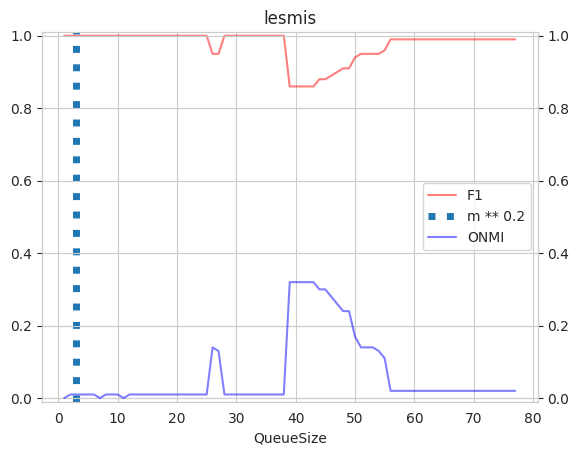

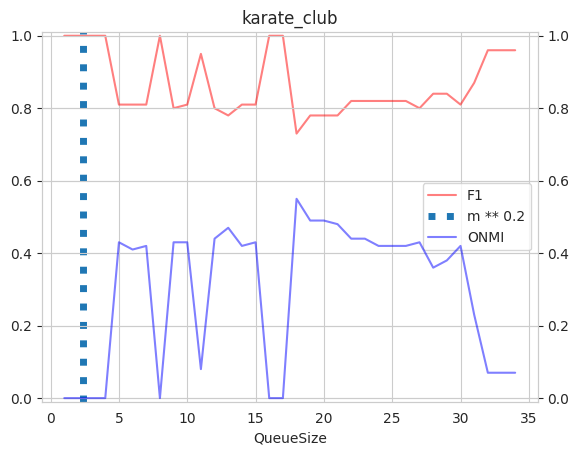

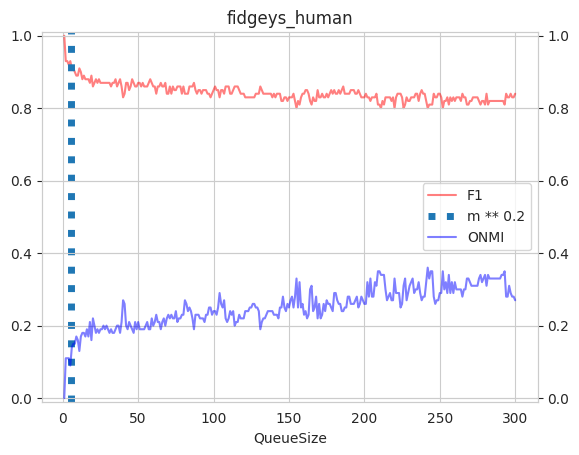

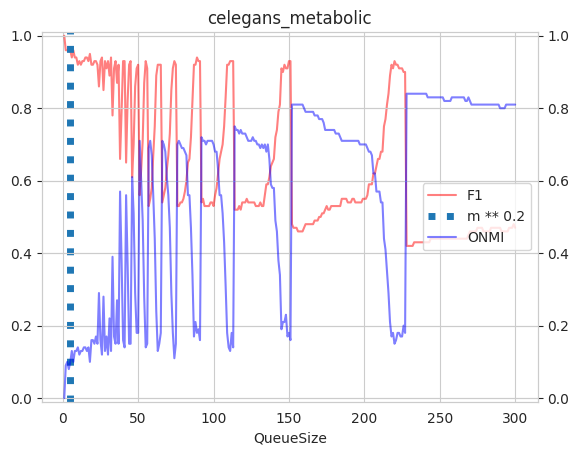

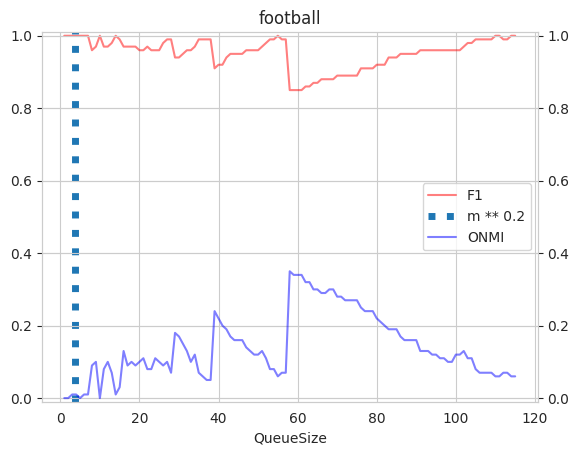

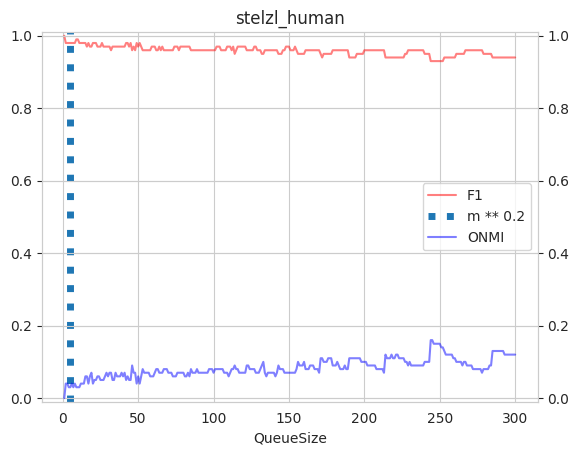

In [12]:
for dataset in datasets:
    plot_dataset(dataset, True)

In [13]:
BAD_ONMI = 0.19
BAD_F1 = 0.9
    
def heuristic_finder(dataset: str):
    g = get_additional_dataset_graph(dataset)

    df = get_dataframe(dataset).sort_values("QueueSize")

    queue_sizes = df[(df["F1"] > BAD_F1) & (df["ONMI"] < BAD_ONMI)]["QueueSize"]

    highest_possible_queue_size = 0
    for q in list(queue_sizes):
        if highest_possible_queue_size + 1 != q:
            # One QueueSize was skipped!
            break
        highest_possible_queue_size = q
    
    
    modifiers = {
        "10%": lambda x: 0.1 * x,
        "20%": lambda x: 0.2 * x,
        "30%": lambda x: 0.3 * x,
        "40%": lambda x: 0.4 * x,
        "50%": lambda x: 0.5 * x,
        "60%": lambda x: 0.6 * x,
        "70%": lambda x: 0.7 * x,
        "80%": lambda x: 0.8 * x,
        "90%": lambda x: 0.9 * x,
        "**0.1": lambda x: x ** 0.1,
        "**0.2": lambda x: x ** 0.2,
        "**0.3": lambda x: x ** 0.3,
        "**0.4": lambda x: x ** 0.4,
        "**0.5": lambda x: x ** 0.5,
        "**0.6": lambda x: x ** 0.6,
        "**0.7": lambda x: x ** 0.7,
        "**0.8": lambda x: x ** 0.8,
        "**0.9": lambda x: x ** 0.9,
    }
    
    density = (2 * g.numberOfEdges() / (g.numberOfNodes() * (g.numberOfNodes() - 1)))

    values = {
        "n": g.numberOfNodes(),
        "m": g.numberOfEdges(),
        "density": density, 
    }
    
    works = {}
    for vname, v in values.items():
        for mname, m in modifiers.items():
            effective = m(v)
            if effective < highest_possible_queue_size:
                works[(vname, mname)] = effective
    
    return works
            

In [14]:
works = []
for dataset in datasets:
    works.append(heuristic_finder(dataset))

In [15]:
from functools import reduce


works_on_all_datasets = reduce(
    lambda m1, m2: set(m1).intersection(set(m2)),
    map(
        lambda x: x.keys(),
        works,
    ),
)

for i, w in enumerate(works):
    print(datasets[i])
    values = sorted(
        [(metric, w[metric]) for metric in works_on_all_datasets],
        reverse=True,
        key=lambda x: x[1],
    )
    
    best_four = values[:4]
    
    printable_best_four = "\n\t".join(map(str, best_four))
    print("\t", printable_best_four)
    
    

lesmis
	 (('m', '**0.2'), 3.0266816470651476)
	(('n', '**0.2'), 2.3839555034549)
	(('m', '**0.1'), 1.7397360854638693)
	(('n', '**0.1'), 1.5440063158727362)
karate_club
	 (('m', '**0.2'), 2.390115677352187)
	(('n', '**0.2'), 2.024397458499885)
	(('m', '**0.1'), 1.5459998956507686)
	(('n', '**0.1'), 1.4228132198218728)
fidgeys_human
	 (('m', '**0.2'), 5.776558916157306)
	(('n', '**0.2'), 4.677467931888594)
	(('m', '**0.1'), 2.403447298393977)
	(('n', '**0.1'), 2.1627454616502133)
celegans_metabolic
	 (('m', '**0.2'), 4.77716316773737)
	(('n', '**0.2'), 3.4009659145500195)
	(('m', '**0.1'), 2.1856722461836244)
	(('n', '**0.1'), 1.844170793215753)
football
	 (('m', '**0.2'), 3.609874427765292)
	(('n', '**0.2'), 2.5830901781308797)
	(('m', '**0.1'), 1.8999669543877051)
	(('n', '**0.1'), 1.6071994829923508)
stelzl_human
	 (('m', '**0.2'), 5.020943806302121)
	(('n', '**0.2'), 4.429919204417828)
	(('m', '**0.1'), 2.240746261026027)
	(('n', '**0.1'), 2.1047373243276293)


In [16]:
old_datasets = {
    "eu" : (1_005, 25_571),
    "dblp" : (317_080, 1_049_866),
    "lj" : (3_997_962, 35_681_189),
    "friendster" : (65_608_366, 1_806_067_135),
}

for name, (n, m) in old_datasets.items():
    print(name)
    print(n ** 0.2)
    print(m ** 0.2)
    print()


eu
3.985044838900241
7.612889786224724

dblp
12.596032424053275
16.00393483173951

lj
20.91065960398394
32.39573692726493

friendster
36.592480016043325
71.01445819874904



There are a few problems with these heuristic experiment results:

First of all, there is not a good heuristic allowing for very good F1 and ONMI scores (like in our original table .99 and .05), which also allows us to also parallelize.

If we define bad and good for F1 and ONMI (BAD_ONMI > 0.19, BAD_F1 < 0.9), we can find a few heuristics, mainly `m ** 0.2` (`5_root(m)`), which allows us to compute good enough results.

However, they cease to work as good indications for large networks. We know we can run DBLP and LJ with high queuesizes without compromise (256 threads, still 0.99 F1 and 0.009 ONMI). But the heuristic would state they can only run with 16 (dblp) or 32 (lj) threads, which makes our contribution worse, as the speed up is not that great anymore.

This also puts our analysis on friendster in question, as it ran with 512 threads., but the heuristic only allows for 71.

We could argue, that the heuristic is only relevant for small scale datasets (which is our initial statment anyways), but we would need to define "small".


More Ideas for heuristic metric candidates:
- 1 / Clustering Coeficient (celegans has a very high CC)
- 1 / Triangle Count * smth (celegans has many triangles)

In [17]:
df = get_dataframe("celegans_metabolic").sort_values("QueueSize")
df

,Dataset,QueueSize,F1,ONMI
243,celegans_metabolic,1,1.00,0.00
8,celegans_metabolic,2,0.96,0.09
130,celegans_metabolic,3,0.96,0.10
125,celegans_metabolic,4,0.96,0.08
129,celegans_metabolic,5,0.96,0.10
...,...,...,...,...
115,celegans_metabolic,296,0.47,0.81
83,celegans_metabolic,297,0.47,0.81
251,celegans_metabolic,298,0.47,0.81
187,celegans_metabolic,299,0.48,0.81
